In [1]:
import scanpy as sc
import pandas as pd
import decoupler as dc
from anndata import AnnData

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import hdf5plugin

In [2]:
path = "../data/brca/tcga/processed/GSE161529/genes_prop_cells_normal.csv"
adata = pd.read_csv(path, sep=",").T

In [3]:
adata.head(5)

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
AV,41368.555136,4308.393332,15791.862875,11459.715061,2663.381203,6855.028705,53952.922614,18238.816906,18856.634170,19851.176204,...,0.0,0.821148,240.653212,0.0,0.554334,4.639425,3103.473036,0.0,82.085558,161.485164
Fibroblast,44.463261,4.560051,20.945320,6.238327,1.578904,7.342455,39.936333,21.784458,14.927819,14.000351,...,0.0,0.000000,0.187702,0.0,0.000000,0.000000,2.671991,0.0,0.077289,0.342280
HS,354714.173434,63984.630010,135319.709582,98330.175712,23902.406858,57153.626169,628169.473822,153026.884736,217833.497751,166481.773745,...,0.0,10.280788,1991.499831,0.0,9.042934,36.663541,33206.573658,0.0,846.080190,919.172327
Vascular and lymphatic,28505.583226,1812.549613,10306.727193,8660.019779,1911.097293,2829.213959,26621.145635,9266.122412,12513.860276,14326.216820,...,0.0,0.621460,159.145974,0.0,1.224573,2.121584,2108.823805,0.0,48.608882,73.988136
Immune,2.537117,0.190607,1.059593,0.627732,0.202395,0.316360,4.214220,1.134690,1.376159,1.114213,...,0.0,0.000000,0.010630,0.0,0.000000,0.000228,0.182870,0.0,0.003843,0.004758


In [4]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 6 × 60660

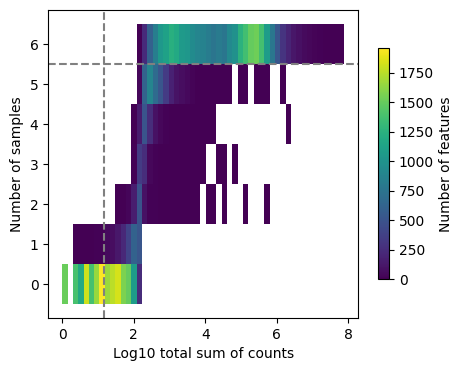

In [5]:
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)


In [6]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 26251

In [7]:
model = dc.get_progeny(organism='human', top=300)
model

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
4195,p53,F5,2.397854,5.746843e-08
4196,p53,MKI67,-5.680340,5.758565e-08
4197,p53,THOC2,-2.108178,5.858359e-08
4198,p53,POLA1,-4.943873,5.911873e-08


In [8]:
pd.unique(model.source)

array(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK',
       'NFkB', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype=object)

In [9]:
adata.X

array([[4.1368555e+04, 4.3083936e+03, 1.5791863e+04, ..., 3.1034731e+03,
        8.2085556e+01, 1.6148517e+02],
       [4.4463261e+01, 4.5600514e+00, 2.0945320e+01, ..., 2.6719913e+00,
        7.7289008e-02, 3.4227988e-01],
       [3.5471419e+05, 6.3984629e+04, 1.3531970e+05, ..., 3.3206574e+04,
        8.4608020e+02, 9.1917230e+02],
       [2.8505584e+04, 1.8125496e+03, 1.0306728e+04, ..., 2.1088237e+03,
        4.8608883e+01, 7.3988136e+01],
       [2.5371170e+00, 1.9060749e-01, 1.0595930e+00, ..., 1.8286991e-01,
        3.8428123e-03, 4.7580707e-03],
       [9.7122688e+04, 2.4137676e+04, 3.7896695e+04, ..., 1.0243274e+04,
        2.6814423e+02, 2.3600734e+02]], dtype=float32)

In [10]:
# Infer pathway activities with consensus
dc.run_consensus(mat=adata, 
                 net=model,
                 use_raw=False, 
                 verbose=True)

Running consensus.


ValueError: No sources with more than min_n=5 targets. Make sure mat and net have shared target features or
        reduce the number assigned to min_n

In [ ]:
adata

In [ ]:
# Extract from dictionary
acts =  adata.obsm['consensus_estimate']
pvals = adata.obsm['consensus_pvals']

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5), tight_layout=True, sharey=True)

axes[0].set_title('Pathway Activity')
sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[1].set_title('p-values')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=1)
path = "../figures/GSE161529/Immune_cell_cancer_pathways.png"
fig.suptitle("Pathway Activity in TCGA Breast Cancer")
plt.savefig(path,format='png')
plt.show()
plt.close()